  CountryRegionCode  storeid                           name  StoreDuration  \
0                CA      412             Gasless Cycle Shop             10   
1                US      574               Fifth Bike Store             10   
2                US      716  Famous Bike Sales and Service             10   
3                US      926                   Unique Bikes             10   
4                US     1018          Trusted Catalog Store             10   

   SquareFeet  TotalRevenue  
0       24000     4839.2987  
1       26000     8663.1794  
2       26000     2931.9869  
3       27000    41335.5260  
4       25000    71038.1450  


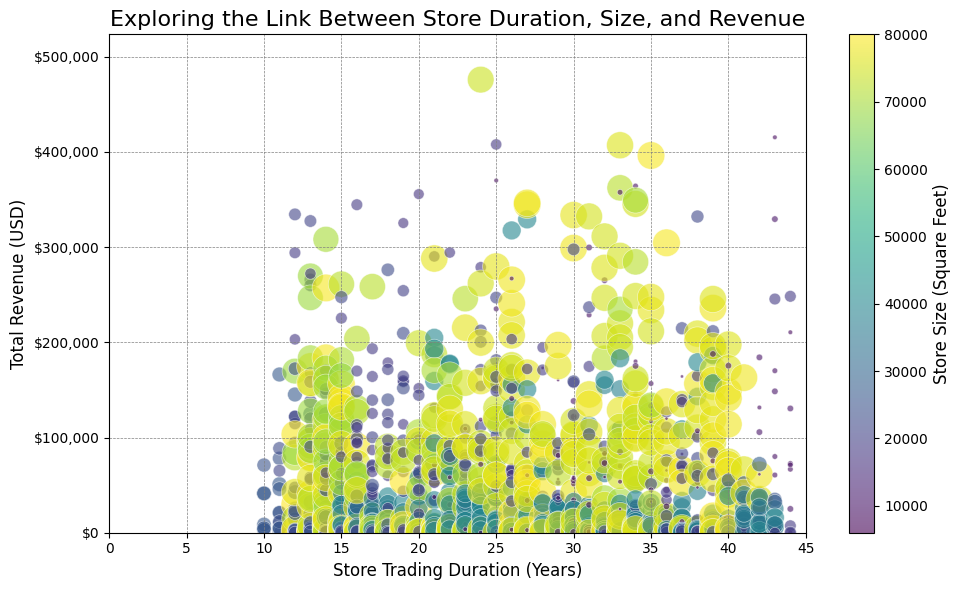

In [ ]:
# For plotting a Bubble Chart based on the data generated on 2010-2014
# Add a third variable (Store Szie) to analysis any impact on the link between store duration and total revenue

from sqlalchemy import create_engine
import pandas as pd

# Create the SQLAlchemy engine using pyodbc driver
connection_string = "mssql+pyodbc://DESKTOP-19LPOE8\\SQLEXPRESS/AdventureWorks2022?driver=ODBC+Driver+17+for+SQL+Server"
engine = create_engine(connection_string)

# SQL query to fetch data from the view
query = """
SELECT 
t.CountryRegionCode,
    c.storeid, 
    s.name, 
    Year(duedate) - YearOpened as StoreDuration, 
    s.SquareFeet ,
    sum(TotalDue) as TotalRevenue  
FROM AdventureWorks2022.Sales.SalesOrderHeader soh  
LEFT JOIN AdventureWorks2022.Sales.Customer c 
    ON soh.CustomerID = c.CustomerID
LEFT JOIN Sales.vStoreWithDemographics s 
    ON s.BusinessEntityID = c.storeid
left join Sales.SalesTerritory t on t.TerritoryID = soh.TerritoryID
WHERE c.storeid IS NOT NULL
GROUP BY t.CountryRegionCode,c.storeid, s.name, Year(duedate) - YearOpened  ,s.SquareFeet 
ORDER BY Year(duedate) - YearOpened, t.CountryRegionCode, c.storeid ,s.SquareFeet 
"""

# Load data into pandas DataFrame
df = pd.read_sql(query, engine)

# Display the first few rows of the data
print(df.head())

# Close the connection
engine.dispose()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from matplotlib import cm

# Assuming df is your DataFrame with StoreDuration, TotalRevenue, and SquareFeet

# Normalize store size (SquareFeet) to an appropriate scale for bubble size
# Normalize so the smallest store (6,000) has a bubble of size ~50, and the largest (80,000) ~1000
norm = plt.Normalize(df['SquareFeet'].min(), df['SquareFeet'].max())
bubble_size = norm(df['SquareFeet']) * 400  # Adjust this factor (1000) to control bubble size

# Create the figure
plt.figure(figsize=(10, 6))

# Scatter plot for TotalRevenue and store size (SquareFeet)
scatter = plt.scatter(df['StoreDuration'], df['TotalRevenue'], 
                      s=bubble_size,  # Bubble size proportional to SquareFeet
                      c=df['SquareFeet'],  # Color by Store Size
                      cmap='viridis', alpha=0.6, edgecolors="w", linewidth=0.5)

# Title and labels
plt.title('Exploring the Link Between Store Duration, Size, and Revenue', fontsize=16, color='black')
plt.xlabel('Store Trading Duration (Years)', fontsize=12, color='black')
plt.ylabel('Total Revenue (USD)', fontsize=12, color='black')

# Format y-axis to display the USD sign ($)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '${:,}'.format(int(x))))

# Add color bar for the store size (SquareFeet)
cbar = plt.colorbar(scatter, orientation='vertical')
cbar.set_label('Store Size (Square Feet)', fontsize=12)

# Set background color
plt.gcf().set_facecolor('white')
plt.gca().set_facecolor('white')

# Set the grid
plt.grid(True, color='grey', linestyle='--', linewidth=0.5)

# Set x and y axis limits
plt.xlim(0, df['StoreDuration'].max() + 1)  # Padding for x-axis
plt.ylim(0, df['TotalRevenue'].max() * 1.1)  # Padding for y-axis

# Customize ticks color
plt.xticks(color='black')
plt.yticks(color='black')

# Show the plot
plt.tight_layout()
plt.show()